# Decision tree classification

First, we're starting off with a simple decision tree. Using only numerical values, we split the data on the cleanest seperation of class labels according to the gini index.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('Data/preprocessedTrain.csv') #import data
X = data.loc[:, data.columns != 'AdoptionSpeed'] #create X without labels
X = X.drop('Description',axis=1) #drop non numerical values
X = X.drop('PetID',axis=1) #
X = X.drop('RescuerID',axis=1)

y = data['AdoptionSpeed'] #label vector

attributeNames = list(X.columns.values) #for printing purposes
classNames = ['sameDay','firstWeek','firstMonth','2nd3rdMonth','notAdopted']

In [34]:
from sklearn import tree
from Toolbox import treeprint
from sklearn import model_selection
import matplotlib.pyplot as plt

test_proportion = 0.5  # set crossval proportion
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=test_proportion)
levels = range(2,51)
error = np.zeros((2,len(levels)))

for t in levels:
    dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=t) #train decision tree
    dtc = dtc.fit(X_train,y_train)
    
    y_est_test = dtc.predict(X_test)
    y_est_train = dtc.predict(X_train)
    
    test_class_error = 1-np.mean(y_est_test == y_test)
    train_class_error = 1-np.mean(y_est_train == y_train)
    error[0,t-2], error[1,t-2]= train_class_error, test_class_error


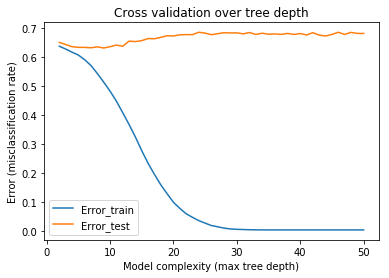

Lowest average error is 0.3380 at 42 using 50.0 percent for testing
Lowest unweighted error is 0.3380 at 42
Lowest test error is 0.6305 at 7


In [35]:
plt.plot(levels, error[0,:])
plt.plot(levels, error[1,:])
plt.xlabel('Model complexity (max tree depth)')
plt.ylabel('Error (misclassification rate)')
plt.legend(['Error_train','Error_test']) 
plt.title('Cross validation over tree depth')
plt.show()  
errorSum = test_proportion*error[1,:] + (1-test_proportion)*error[0,:] # mean error
error_equal = sum(error)
print('Lowest average error is {:.4f} at {} using {} percent for testing'.format(min(errorSum), np.argmin(errorSum),test_proportion*100))
print('Lowest unweighted error is {:.4f} at {}'.format(min(error_equal)/2,np.argmin(error_equal)))
print('Lowest test error is {:.4f} at {}'.format(min(error[1,:]),np.argmin(error[1,:])))

dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=np.argmin(errorSum)) #find relevant attributes
dtc = dtc.fit(X,y)

attribute_importance = [(attributeNames[i],dtc.feature_importances_[i]) for i in range(len(attributeNames))]
attributes_sorted = sorted(attribute_importance, key=lambda item: item[1], reverse=True)

In [36]:
print('Features in order of importance:')
print(*['{}: {:.4f}'.format(i[0],i[1]) for i in attributes_sorted],sep='\n')

Features in order of importance:
PhotoAmt: 0.0963
Age: 0.0912
Breed1: 0.0690
Color2: 0.0667
Color1: 0.0589
State: 0.0500
Breed2: 0.0395
FurLength: 0.0333
Gender: 0.0326
Color3: 0.0318
MaturitySize: 0.0316
adopt: 0.0297
Quantity: 0.0291
Vaccinated: 0.0287
Dewormed: 0.0274
Fee: 0.0263
Sterilized: 0.0235
love: 0.0235
play: 0.0207
friend: 0.0206
good: 0.0201
health: 0.0169
vaccin: 0.0153
activ: 0.0140
cute: 0.0133
Name: 0.0123
ador: 0.0121
sweet: 0.0116
abandon: 0.0089
VideoAmt: 0.0089
beaut: 0.0086
Health: 0.0063
great: 0.0058
fun: 0.0058
best: 0.0041
energ: 0.0034
Type: 0.0019


In [37]:
dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth = 5)
dtc = dtc.fit(X,y)


treeprint.tree_print(dtc, attributeNames, classNames) #plot smol tree





               |->5  firstWeek
               |
            |->4 then if Name =< 0.50: go to 5, else go to 6
            |  |
            |  |->6  2nd3rdMonth
            |
         |->3 then if Type =< 1.50: go to 4, else go to 7
         |  |
         |  |  |->8  notAdopted
         |  |  |
         |  |->7 else if Color3 =< 6.50: go to 8, else go to 9
         |     |
         |     |->9  notAdopted
         |
      |->2 then if PhotoAmt =< 0.50: go to 3, else go to 10
      |  |
      |  |     |->12  firstWeek
      |  |     |
      |  |  |->11 then if Quantity =< 3.50: go to 12, else go to 13
      |  |  |  |
      |  |  |  |->13  firstMonth
      |  |  |
      |  |->10 else if Breed2 =< 306.50: go to 11, else go to 14
      |     |
      |     |  |->15  2nd3rdMonth
      |     |  |
      |     |->14 else if Dewormed =< 2.50: go to 15, else go to 16
      |        |
      |        |->16  2nd3rdMonth
      |
   |->1 then if Breed1 =< 306.50: go to 2, else go to 17
   |  |
   |  |  

In [38]:
#print(X_train)
#help(tree._tree.Tree)
#X_train.sf()
treeRows = []
afterTree = dtc.predict(X_test)#predicted from tree


### Decision tree classifier results

Based on the small decision tree, the most important factors in order are: Age, breed, photo. Other relevant factors are Vaccinated, certain key words in the description.

Based on the error plots, the model does not generalize well to test data. 

# Random forest

Now we try with a random forest of decision trees.

In [39]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

estimators = np.logspace(1,3,num=3,base=10)
error = np.zeros((2,len(estimators)))

for n_e in estimators:
    rf = RandomForestRegressor(n_estimators = int(n_e))
    # Train the model on training data
    rf = rf.fit(X_train, y_train)
    
    y_est_test = rf.predict(X_test)
    y_est_train = rf.predict(X_train)
    
    test_class_error = 1-np.mean(np.round(y_est_test,0) == y_test)
    train_class_error = 1-np.mean(np.round(y_est_train,0) == y_train)
    error[0,int(np.log10(n_e)-1)], error[1,int(np.log10(n_e)-1)]= train_class_error, test_class_error


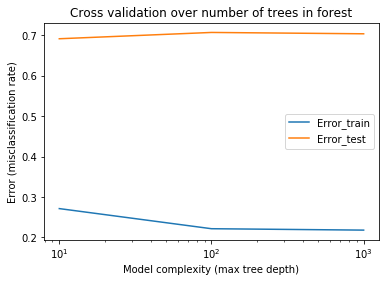

Lowest average error is 0.4609 at 1000.0 using 50.0 percent for testing
Lowest unweighted error is 0.4609 at 1000.0
Lowest test error is 0.6915 at 0
[[0.27134472 0.22158485 0.21811633]
 [0.69147659 0.70708283 0.70374817]]


In [40]:
plt.semilogx(estimators, error[0,:])
plt.semilogx(estimators, error[1,:])
plt.xlabel('Model complexity (max tree depth)')
plt.ylabel('Error (misclassification rate)')
plt.legend(['Error_train','Error_test']) 
plt.title('Cross validation over number of trees in forest')
plt.show()  


errorSum = test_proportion*error[1,:] + (1-test_proportion)*error[0,:] # mean error
error_equal = sum(error)
print('Lowest average error is {:.4f} at {} using {} percent for testing'.format(min(errorSum), estimators[np.argmin(errorSum)],test_proportion*100))
print('Lowest unweighted error is {:.4f} at {}'.format(min(error_equal)/2,estimators[np.argmin(error_equal)]))
print('Lowest test error is {:.4f} at {}'.format(min(error[1,:]),np.argmin(error[1,:])))

print(error)

### Random forest results

Does not seem to perform better than a single decision tree.

# Logistic regression

In [41]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_est_test = logreg.predict(X_test)
y_est_train = logreg.predict(X_train)

test_class_error = 1-np.mean(np.round(y_est_test,0) == y_test)
train_class_error = 1-np.mean(np.round(y_est_train,0) == y_train)

print('Test error: {:.4f}'.format(test_class_error))
print('Training error: {:.4f}'.format(train_class_error))

Test error: 0.6849
Training error: 0.6796


# K-Nearest Neighbors

In [42]:
from sklearn.neighbors import KNeighborsClassifier
ks = []
y_est_tests = []
y_est_trains = []
test_class_errors = []
train_class_errors = []
for k in range(15):
    ks.append(KNeighborsClassifier(k+2))
    ks[k].fit(X_train, y_train)
    
    y_est_tests.append(ks[k].predict(X_test))
    y_est_trains.append(ks[k].predict(X_train))
    
    test_class_errors.append(1-np.mean(np.round(y_est_tests[k],0) == y_test))
    train_class_errors.append(1-np.mean(np.round(y_est_trains[k],0) == y_train))

    print('Test error k = ', k+2 ,': {:.4f}'.format(test_class_errors[k]))
    print('Training error k = ', k+2 ,': {:.4f}'.format(train_class_errors[k]))

error = [train_class_errors, test_class_errors]
error_equal = []
for e in range(len(error[0])):
    error_equal.append(error[0][e] + error[1][e])

print('Lowest average error is {:.4f} at {} using {} percent for testing'.format(min(test_class_errors), np.argmin(train_class_errors)+2,test_proportion*100))
print('Lowest unweighted error is {:.4f} at {}'.format(min(error_equal)/2,np.argmin(error_equal)+2))
print('Lowest test error is {:.4f} at {}'.format(min(error[1]),np.argmin(error[1])))
ktests = y_est_tests

Test error k =  2 : 0.7100
Training error k =  2 : 0.3513
Test error k =  3 : 0.6884
Training error k =  3 : 0.3930
Test error k =  4 : 0.6879
Training error k =  4 : 0.4325
Test error k =  5 : 0.6755
Training error k =  5 : 0.4586
Test error k =  6 : 0.6741
Training error k =  6 : 0.4848
Test error k =  7 : 0.6705
Training error k =  7 : 0.4957
Test error k =  8 : 0.6780
Training error k =  8 : 0.5013
Test error k =  9 : 0.6705
Training error k =  9 : 0.5147
Test error k =  10 : 0.6680
Training error k =  10 : 0.5279
Test error k =  11 : 0.6688
Training error k =  11 : 0.5348
Test error k =  12 : 0.6656
Training error k =  12 : 0.5390
Test error k =  13 : 0.6644
Training error k =  13 : 0.5423
Test error k =  14 : 0.6643
Training error k =  14 : 0.5484
Test error k =  15 : 0.6608
Training error k =  15 : 0.5502
Test error k =  16 : 0.6625
Training error k =  16 : 0.5544
Lowest average error is 0.6608 at 2 using 50.0 percent for testing
Lowest unweighted error is 0.5306 at 2
Lowest tes

ValueError: x and y must have same first dimension, but have shapes (16,) and (15,)

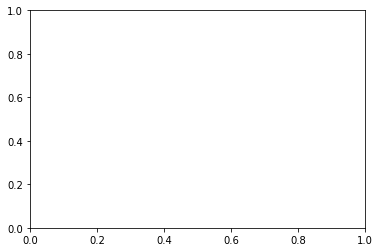

In [43]:
plt.plot(range(1,len(ks)+2),train_class_errors)
plt.plot(range(1,len(ks)+2),test_class_errors)
plt.xlabel('k')
plt.ylabel('Error (misclassification rate)')
plt.legend(['Error_train','Error_test']) 
plt.title('Effectiveness through different k\'s')
plt.show()

# Support Vector Machine

In [44]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)

y_est_test = svm.predict(X_test)
y_est_train = svm.predict(X_train)

test_class_error = 1-np.mean(np.round(y_est_test,0) == y_test)
train_class_error = 1-np.mean(np.round(y_est_train,0) == y_train)

print('Test error: {:.4f}'.format(test_class_error))
print('Training error: {:.4f}'.format(train_class_error))

Test error: 0.6475
Training error: 0.3126


# Naive Bayes

In [45]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_est_test = gnb.predict(X_test)
y_est_train = gnb.predict(X_train)

test_class_error = 1-np.mean(np.round(y_est_test,0) == y_test)
train_class_error = 1-np.mean(np.round(y_est_train,0) == y_train)

print('Test error: {:.4f}'.format(test_class_error))
print('Training error: {:.4f}'.format(train_class_error))

Test error: 0.8427
Training error: 0.8299


In [46]:
dtc = dtc.predict(X_test)
rf = rf.predict(X_test)
logreg = logreg.predict(X_test)
svm = svm.predict(X_test)
gnb = gnb.predict(X_test)
    
def majorityVote(x):
    maj = [0,0,0,0,0]
    def majority(y):#Do this once for each classifier
        if(y == 0):
            maj[0] = maj[0] + 1
        if(y == 1): 
            maj[1] = maj[1] + 1
        if(y == 2):
            maj[2] = maj[2] + 1
        if(y == 3):
            maj[3] = maj[3] + 1
        if(y == 4):
            maj[4] = maj[4] + 1
    majority(dtc[x])
    majority(rf[x])
    majority(logreg[x])
    majority(ktests[-1][x])
    majority(svm[x])
    majority(gnb[x])

    if(max(maj) == maj[0]):
        return 0
    if(max(maj) == maj[1]):
        return 1
    if(max(maj) == maj[2]):
        return 2
    if(max(maj) == maj[3]):
        return 3
    if(max(maj) == maj[4]):
        return 4

combined = []
for x in range(len(X_test)):
    combined.append(majorityVote(x))
print(combined)

#check against actual labels

[4, 2, 4, 4, 2, 2, 2, 1, 3, 1, 2, 2, 4, 2, 2, 4, 2, 1, 4, 4, 4, 2, 1, 4, 4, 4, 2, 4, 4, 4, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 4, 4, 2, 4, 4, 2, 4, 4, 4, 4, 4, 2, 4, 2, 4, 2, 1, 3, 4, 1, 2, 4, 2, 1, 1, 2, 2, 4, 4, 4, 4, 1, 4, 4, 3, 2, 1, 1, 2, 4, 1, 4, 2, 2, 2, 4, 4, 4, 1, 4, 2, 4, 2, 2, 1, 2, 4, 4, 2, 4, 3, 4, 2, 2, 2, 2, 4, 2, 4, 4, 2, 4, 4, 2, 4, 3, 1, 4, 2, 2, 4, 2, 1, 4, 1, 4, 2, 2, 1, 1, 4, 4, 2, 4, 1, 2, 2, 2, 2, 2, 4, 4, 4, 1, 2, 4, 4, 3, 1, 4, 1, 2, 4, 4, 2, 4, 4, 4, 1, 4, 2, 4, 1, 2, 4, 2, 1, 4, 2, 1, 4, 1, 1, 4, 2, 4, 2, 4, 1, 2, 2, 4, 3, 4, 4, 2, 2, 2, 1, 2, 2, 2, 2, 2, 4, 4, 1, 4, 4, 2, 1, 4, 4, 2, 3, 1, 4, 4, 2, 2, 2, 4, 3, 1, 3, 1, 2, 1, 2, 4, 2, 4, 4, 1, 2, 1, 2, 4, 2, 2, 4, 4, 4, 4, 1, 1, 2, 2, 4, 4, 4, 4, 4, 4, 2, 1, 2, 4, 2, 4, 1, 2, 1, 1, 2, 2, 4, 2, 2, 3, 4, 2, 1, 2, 4, 1, 4, 4, 2, 2, 1, 2, 4, 4, 2, 2, 3, 4, 4, 2, 4, 2, 4, 4, 4, 1, 4, 3, 2, 1, 1, 4, 3, 1, 2, 2, 0, 4, 1, 2, 2, 4, 1, 4, 4, 2, 4, 2, 2, 2, 4, 4, 2, 2, 2, 4, 4, 3, 2, 1, 4, 2, 2, 2, 4, 4, 2, 4, 2, 4, 1, 4, 4, 